# Grover's algorithm and Quantum Search with N = 2,3,4 qubits

This excercise deals with the implementation of Grover's algorithm with Qiskit. We will consider $n = 2, 3, 4$ qubits, which allows to deal with $2^n$ entries.

A nice explanation of the algorithm and its implementation with Qiskit can be found here:

https://qiskit.org/textbook/ch-algorithms/grover.html

This notebook builds on the documentation above. It has moslty a pedagogical value: it helps clarifying the main working principles of the algorithm, as well as the difficulties found when implementing Oracle and Inversion operators in practice. 

The Grover's algorithm will be also explained in Diego Porras' lecture on the first school day. This algorithm relies on the application of the Grover operator,

$$
G = (2 |\psi\rangle \langle \psi | - I) O
$$

where $O$ is the so-called oracle operator, and $(2 |\psi\rangle \langle \psi | - I)$ is the inversion operator. The joint action of those operators lead to the amplitude amplification effect that is the basis for quantum search.

To fully understand the algorithm, you can either wait for Diego's talk, or read the qiskit documentation above. The basis of the algorithm is the multi-qubit controlled-Z gate, which is somehow independent of the details of Grover's algorithm.

In [4]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

## The multi-qubit controlled-Z gate

The backbone of Grover's alrogithm is the multi-quibt controlled-Z gate. This is a gate that carries out the following quantum operation:

$$U^{[n]}_{mqZ} = -2 |1 1 1 1 \dots 1 \rangle \langle 1 1 1 1 \dots 1 | + \mathbf{I}.$$

It is generally a quite complex task to build such a gate. We will see below examples with $n = 2$, $3$, $4$ qubits. In the book by Nielsen and Chuang, page 184, they show a general procedure to build this multi-qubit gate in general with Toffoli gates and additional ancilla (extra) qubits. Here we will avoid the use of extra qubits.

Note that $U^{[n]}_{mqZ}$ multiplies a quantums state conditioned to all qubits being in state $|1\rangle$. This operation is not trivial at all and it is difficult to scale to many-qubits. 

Remember that Grover's algorithm does require in fact a slightly different operator to be used as inversion operator:

$$U_{inv} = -2 |0 0 0 \dots 0 \rangle \langle 0 0 0 \dots 0 | + \mathbf{I}$$

We can easliy express $U_{inv}$ in terms of $U_{mqZ}$ by using X-gates, which just swap $|0\rangle$ and $|1\rangle$:

$$U_{inv} = X^{\otimes n} U_{mqZ} X^{\otimes n}$$

The cases with $n = 2$, $3$ are quite simple. $n = 2$ is the usual controlled-Z gate. Let us define a function that implements this quantum circuit:

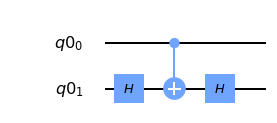

In [5]:
def cz(circuit,qr):
    circuit.h(qr[1])
    circuit.cx(qr[0],qr[1])
    circuit.h(qr[1])
    
qr2 = QuantumRegister(2)
czCircuit = QuantumCircuit(qr2)
cz(czCircuit,qr2)
czCircuit.draw(output="mpl")

The case $n = 3$ can be easily build with the so called Toffoli gate:

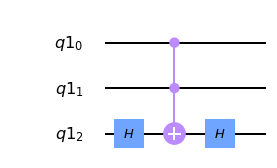

In [6]:
def ccz(circuit,qr):
    circuit.h(qr[2])
    # ccx is the Toffoli gate 
    circuit.ccx(qr[0], qr[1], qr[2])
    circuit.h(qr[2])
    
qr3 = QuantumRegister(3)
cczCircuit = QuantumCircuit(qr3)
ccz(cczCircuit,qr3)
cczCircuit.draw(output="mpl")

The case $n = 4$ is more difficult. We will use an implementation that only uses Controlled NOT gates and phase gates

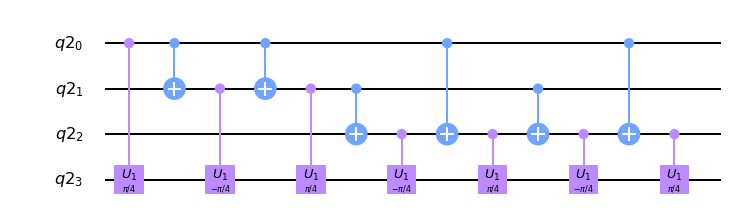

In [7]:
def cccz(circuit,qr):
    pi = math.pi
    circuit.cu1(pi/4,qr[0],qr[3])
    circuit.cx(qr[0], qr[1])
    circuit.cu1(-pi/4, qr[1],qr[3])
    circuit.cx(qr[0], qr[1])
    circuit.cu1(pi/4, qr[1],qr[3])
    circuit.cx(qr[1], qr[2])
    circuit.cu1(-pi/4, qr[2],qr[3])
    circuit.cx(qr[0], qr[2])
    circuit.cu1(pi/4, qr[2],qr[3])
    circuit.cx(qr[1], qr[2])
    circuit.cu1(-pi/4, qr[2],qr[3])
    circuit.cx(qr[0], qr[2])
    circuit.cu1(pi/4, qr[2],qr[3])

qr4 = QuantumRegister(4)
ccczCircuit = QuantumCircuit(qr4)
cccz(ccczCircuit,qr4)
ccczCircuit.draw(output="mpl")

Below we define a multiqubit controlled-Z gate for N = 2,3,4 ions. The function counts the number of control qubits.

In [8]:
def n_controlled_Z(circuit, qr):
    """Implement a Z gate with multiple controls"""
    if (len(qr) > 4):
        raise ValueError('The controlled Z with more than 3 controls is not implemented')
    # This is the case n = 2 (1 control + 1 target qubit)
    elif (len(qr) == 2):
        cz(circuit,qr)
    # This is the case n = 3 (2 control + 1 target qubit)
    elif (len(qr) == 3):
        ccz(circuit,qr)
        # This is the case n = 4 (3 control + 1 target qubit)
    elif (len(qr) == 4):
        cccz(circuit,qr)

###    * Excercise 1
Check out that the above definitions really implement the multi-quit controlled-Z gate. In the cases $n = 2, 3$, you can show it explicitly with pen and paper, or just by checking with Qiskit how the function acts on different input states. The case $n = 4$ is more complicated and we recommend that you just check it numerically.

## Implementing the phase oracle circuit

An oracle is a circuit that "detects" one of the possible states of the computer (the searched elemetn) and changes the sign of the wavefunction, if the system is that state.

This opearation is implemented by the function "phase_oracle", which defines an oracle unitary transformation that multiplies a state with $(-1)$ sign only if the state corresponds to a certain database entry $s_1 s_2 s_3 s_4$. The state is selected by the argument "element", which is a vector of numbers that defines the databse that the algorithm is searching for (e.g. element = $[0,0,1,0]$).

Basically, the function implements the unitary transformation.

$$ | x \rangle \to | x \rangle \ \ {\rm if } x \neq element$$

$$ | x \rangle \to - |x \rangle \ \ {\rm if} x = element $$

The function relies on the multiqubit contolled z-gate defined above. Remember, the latter adds a sign as long as $s = |1111\rangle$. What we have to do is just to flip qubits depending on the particular search term $s$, apply the multiqubit controlled gate, then undo the spin flips:

$$
U_{oracle} = \bigotimes_j X^{1 + s_j} U_{mqZ} \bigotimes_j X^{1 + s_j}
$$

In [9]:
def phase_oracle(circuit,qr,element):
    # element is an array that defines the searched element, for example, element =  [0,1,0,1]
    n = len(element)
    for j,x in enumerate(element):
        if (x == 0):
            circuit.x(qr[j])
    n_controlled_Z(circuit,qr) 
    for j,x in enumerate(element):
        if (x == 0):
            circuit.x(qr[j])

###    * Excercise 2
Check whether this function acts as expected. (Hint: you could, for example, make some rotation on one of the qubits depend on whether the wavefunction gets the right sign or not. Thus, when you measure the final state, you will detect whether the right sign has been added by looking at the output.)

## Implementation of the inversion operator

The function below implements the inversion unitary, which is the second part of the Grover operator. 
This function is a reflection around the state $|\psi\rangle$, that is defined as:

$$|\psi\rangle = H^{\otimes n} |0\rangle_1 |0\rangle_2 \dots |0\rangle_n = \frac{1}{\sqrt{2^n}} 
\sum_{s_1,\dots,s_n} |s_1 \rangle \dots  |s_n \rangle $$

(see Diego's talk or this [webpage](https://qiskit.org/textbook/ch-algorithms/grover.html) )
The inversion is implemented by the following unitary

$$U_{inv} = H^{\otimes n} (-2 |00 \dots 00\rangle \langle 00 \dots 00 | + {\mathbf I}) H^{\otimes n}$$

As you can see, it is basically identically to the multi-qubit controlled-Z gate that we introduced above. 

In [10]:
def inversion_about_average(circuit, register, n):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    n_controlled_Z(circuit, qr)
    circuit.x(register)
    circuit.h(register)

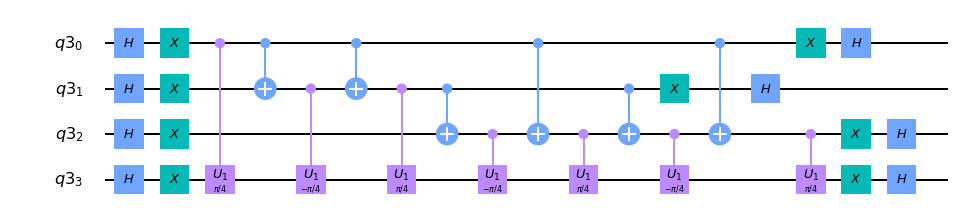

In [11]:
#Let's plot it!
qr = QuantumRegister(4)
qAverage = QuantumCircuit(qr)
inversion_about_average(qAverage, qr, 4)
qAverage.draw(output='mpl')

## Implementation of Grover's algorithm

We are in a position now to implement Grover's algorithm. We can tune the parameter $R$ = number of applications of the Grover transformation and $N = 2,3,4$ qubits

### * Excercise 3 
Use the subroutines above and write down a quantum circuit that implements Grover's algorithm with $n = 2, 3, 4$ qubits, and a given number of repetitions $R$, and searched element $= [s_1, s_2, \dots]$

### * Excercise 4

Explore aspects of the Grover algorithm such as the efficiency as a funciton of the number of repetions, $R$, or the number of measurements that you need to carry out to measure the searched element.